In [1]:
# import all necessary libraries
!pip install mysql-connector-python
!pip install vaderSentiment
!pip install pmdarima
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
import tensorflow
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time
import json
import re
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pickle
from datetime import datetime
from datetime import timedelta
import requests
from requests.auth import AuthBase
import config
import tools
import mysql.connector
import urllib.parse
from mysql.connector import errorcode
import sqlite3
%matplotlib inline
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Tesla

In [2]:
# reload from pickle checkpoint
with open('pickle-folder/tsla_week2_data.pkl', 'rb') as f:
    data = pickle.load(f)
data

,avg_price,compound_sentiment,tweet_count,trade_volume
0,,,,
2020-05-20 05:01:00,808.01000,0.000000,2.0,0.0
2020-05-20 05:02:00,808.01000,0.146800,3.0,0.0
2020-05-20 05:03:00,808.01000,0.000000,1.0,0.0
2020-05-20 05:04:00,808.01000,0.101150,2.0,0.0
2020-05-20 05:05:00,808.01000,0.724500,1.0,0.0
...,...,...,...,...
2020-05-22 15:56:00,817.26500,-0.092133,0.0,29073.0
2020-05-22 15:57:00,817.19495,0.047900,4.0,31711.0
2020-05-22 15:58:00,817.14480,-0.464467,3.0,33391.0


/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

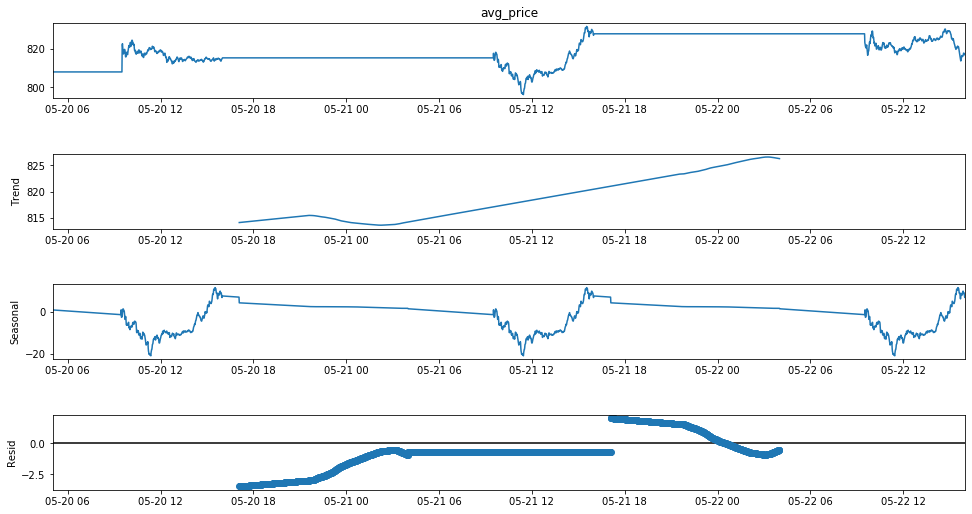

In [3]:
decomposition = seasonal_decompose(data['avg_price'], freq=24*60 )
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [4]:
from statsmodels.tsa.stattools import adfuller

#create a function that will help us to quickly 
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)



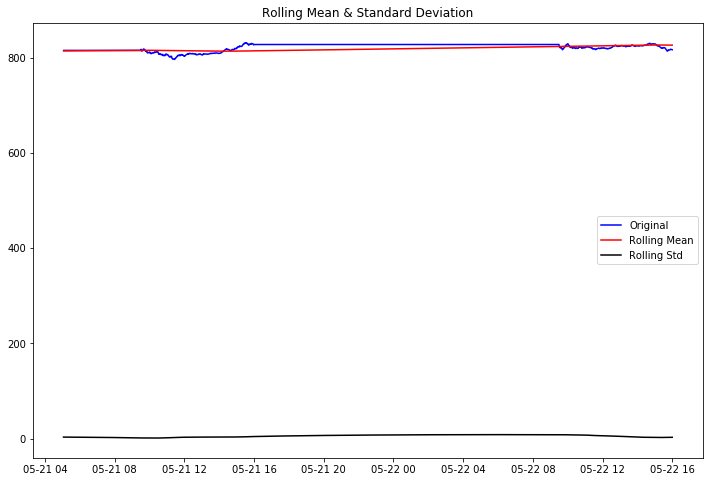

Results of Dickey-Fuller Test:
Test Statistic                   -2.073458
p-value                           0.255320
#Lags Used                       14.000000
Number of Observations Used    3520.000000
Critical Value (1%)              -3.432209
Critical Value (5%)              -2.862361
Critical Value (10%)             -2.567207
dtype: float64


In [5]:
#test the stationarity of the untransformed dataset
test_stationarity(data['avg_price'], 24*60)

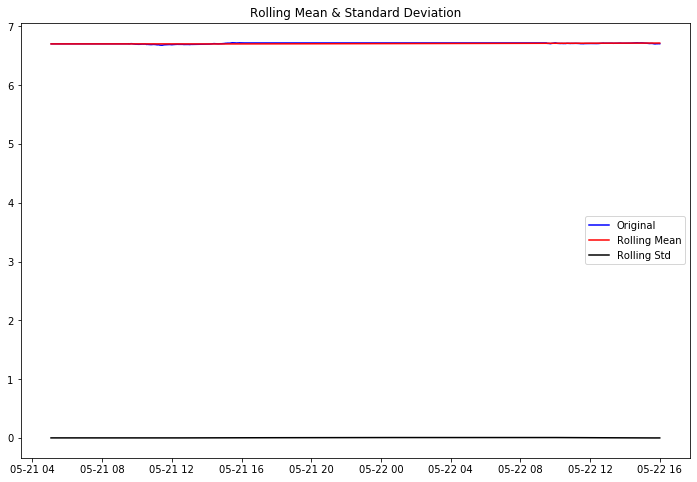

Results of Dickey-Fuller Test:
Test Statistic                   -2.080326
p-value                           0.252499
#Lags Used                       14.000000
Number of Observations Used    3520.000000
Critical Value (1%)              -3.432209
Critical Value (5%)              -2.862361
Critical Value (10%)             -2.567207
dtype: float64


In [6]:
data['log_price'] = data['avg_price'].apply(lambda x: np.log(x))  
test_stationarity(data['log_price'], 24*60)

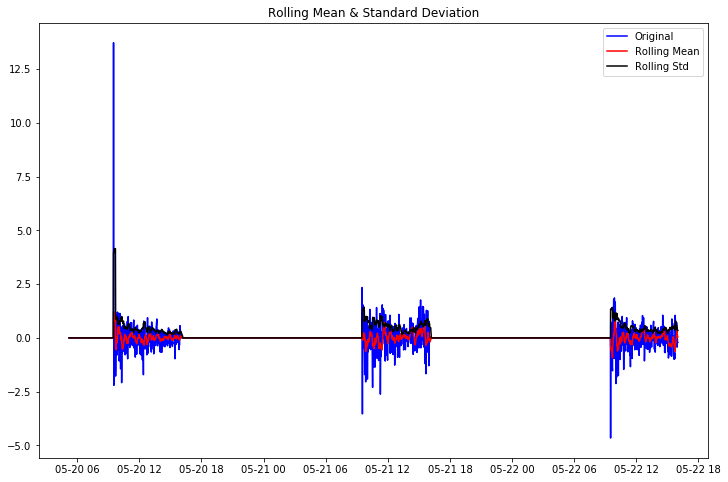

Results of Dickey-Fuller Test:
Test Statistic                -1.771484e+01
p-value                        3.489191e-30
#Lags Used                     1.300000e+01
Number of Observations Used    3.520000e+03
Critical Value (1%)           -3.432209e+00
Critical Value (5%)           -2.862361e+00
Critical Value (10%)          -2.567207e+00
dtype: float64


In [7]:
data['price_first_difference'] = data['avg_price'] - data['avg_price'].shift(1)  
test_stationarity(data['price_first_difference'].dropna(inplace=False),12)

In [8]:
lagged = data['avg_price'].shift(1)
k = lagged.fillna(method='bfill')

In [9]:
lagged_df = pd.concat([data['avg_price'], k], axis=1, keys=['avg_price', 'lagged_price'])
lagged_df

,avg_price,lagged_price
0,,
2020-05-20 05:01:00,808.01000,808.01000
2020-05-20 05:02:00,808.01000,808.01000
2020-05-20 05:03:00,808.01000,808.01000
2020-05-20 05:04:00,808.01000,808.01000
2020-05-20 05:05:00,808.01000,808.01000
...,...,...
2020-05-22 15:56:00,817.26500,817.69500
2020-05-22 15:57:00,817.19495,817.26500
2020-05-22 15:58:00,817.14480,817.19495


No handles with labels found to put in legend.


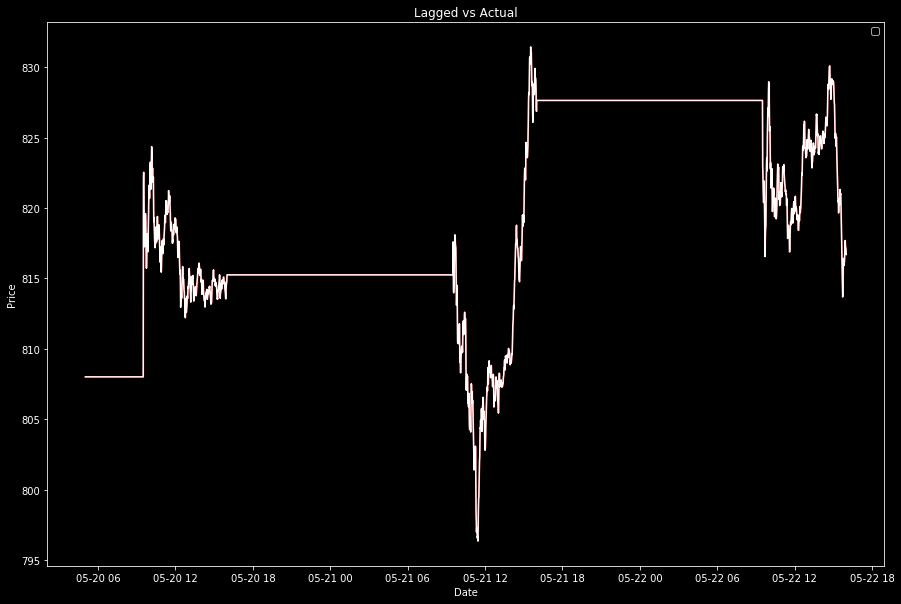

In [10]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Lagged vs Actual')
    plt.plot(data.index[:], lagged_df['lagged_price'], color='red')
    plt.plot(data.index[:], lagged_df['avg_price'], color='white')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

In [12]:
def calc_rmse(y_test, y_pred):
    return (sum([(y_test[i] - y_pred[i])**2 for i in range(len(y_test))])/len(y_test))**(1/2)


def calc_mae(y_test, y_pred):
    return (sum([abs(y_test[i] - y_pred[i]) for i in range(len(y_test))])/len(y_test))

rmse = calc_rmse(lagged_df['avg_price'], lagged_df['lagged_price'])
mae = calc_mae(lagged_df['avg_price'], lagged_df['lagged_price'])
print('RMSE:', rmse)
print('RMSE/std_dev', rmse/lagged_df['avg_price'].std())
print('MAE:', mae)

RMSE: 0.4067758364890205
RMSE/std_dev 0.05606561986605008
MAE: 0.14197321074964533
